In [1]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

# import pytensor.tensor.subtensor as subtensor
# import pytensor.tensor as tensor
# import pytensor.sparse as sparsetensor
import arviz as az

import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing
from pytensor import grad as ptgrad
import numpy as np
from tqdm import tqdm
from pytensor import sparse

import scienceplots
# plot params
contour_levels = 20
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [2]:
import sympy as sp

# Define the size of the blocks
n_u = sp.symbols('n_u', integer=True)

# Define the block matrix C
Z = sp.MatrixSymbol('Z', n_u, n_u)

# Create the block matrix B
zero_block = sp.ZeroMatrix(n_u, n_u)
inner = sp.BlockMatrix([[Z, zero_block, zero_block],
                    [zero_block, zero_block, zero_block],
                    [zero_block, zero_block, zero_block]])

# Define the blocks of matrix A
E = sp.MatrixSymbol('E', n_u, n_u)
F = sp.MatrixSymbol('F', n_u, n_u)
J = sp.MatrixSymbol('J', n_u, n_u)
K = sp.MatrixSymbol('K', n_u, n_u)
L = sp.MatrixSymbol('L', n_u, n_u)
N = sp.MatrixSymbol('N', n_u, n_u)

# Define zero blocks
zero_block = sp.ZeroMatrix(n_u, n_u)

# Construct the block matrix A
outer = sp.BlockMatrix([[E, F, zero_block],
                    [zero_block, J, K],
                    [L, zero_block, N]])

A = J
B = K
C = -L*E.inv()*F
D = N
S = D-C*A.inv()*B
U = -F*A.inv()*B
V = L

inv_11 = E.inv() + E.inv()*(U*S.inv()*V)*E.inv()
inv_12 = -E.inv() * (F-U*S.inv()*C)*A.inv()
inv_13 = -E.inv()*U*S.inv()
inv_21 = -A.inv()*(-B*S.inv()*V)*E.inv()
inv_22 = A.inv() + A.inv()*B*S.inv()*C*A.inv()
inv_23 = -A.inv()*B*S.inv()
inv_31 = -S.inv()*V*E.inv()
inv_32 = -S.inv()*C*A.inv()
inv_33 = S.inv()


outer_inv = sp.BlockMatrix(
    [[inv_11, inv_12, inv_13],
     [inv_21, inv_22, inv_23],
     [inv_31, inv_32, inv_33]]
)

outer_inv_T = outer_inv.T

# Recalculate the product A^(-1) * B * A^(-T)
result = outer_inv * inner * outer_inv_T

sp.block_collapse(result).blocks[0,0]

(E**(-1) - E**(-1)*F*J**(-1)*K*(L*E**(-1)*F*J**(-1)*K + N)**(-1)*L*E**(-1))*Z*(E.T**(-1) - E.T**(-1)*L.T*(K.T*J.T**(-1)*F.T*E.T**(-1)*L.T + N.T)**(-1)*K.T*J.T**(-1)*F.T*E.T**(-1))

In [198]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 200

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = 0.
x_axis_right_boundary = 20

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.025
t_end = 20. #50.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

true_alpha = 1.
true_beta = 0.01
true_c = 0.
true_nu = 0.

# h_1 = 0.232
# h_2 = 0.058
# H_true = 0.29
# rho_zero = 1000
# del_rho = 20
# g_prime = (del_rho*9.8)/rho_zero
# true_nu = 3e-1#3
# true_c = np.sqrt((g_prime*h_1*h_2)/H_true)
# true_beta = (true_c*h_1*h_2)/6
# true_alpha = (3/2)*((true_c*(h_1-h_2))/(h_1*h_2))

mesh = fem.MeshLine(x_s)
v_element = fem.ElementLineP0()
u_element = fem.ElementLineP1()
u_basis = fem.Basis(mesh, u_element)
v_basis = fem.Basis(mesh, v_element)

newton_tol = 0.00001

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*true_coordinates).flatten()
#u_0 = np.exp((-(true_coordinates.flatten())**2)/2)

def sech(x):
    return 1 / np.cosh(x)

u_0true = -0.3*(sech(true_coordinates.flatten() - 15))**2
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

u_guess = u_0true + np.random.normal(0, 0.0001, len(u_0true))
u_guess[0] = u_guess[-1] 
u_guess[-2] = u_guess[1]

v_0true = np.gradient(u_0true)
v_strue = np.zeros((number_of_steps, n_x))
v_strue[0,:] = v_0true

v_guess = v_0true + np.random.normal(0, 0.0001, len(v_0true))
v_guess[0] = v_guess[-1]
v_guess[-2] = v_guess[1]

w_0true = np.gradient(v_0true)
w_strue = np.zeros((number_of_steps, n_x))
w_strue[0,:] = w_0true

w_guess = w_0true + np.random.normal(0, 0.0001, len(w_0true))
w_guess[0] = w_guess[-1]
w_guess[-2] = w_guess[1]

In [199]:
@fem.BilinearForm
def mass(u,v,w):
    return u*v

mass_mat = mass.assemble(ubasis=u_basis, vbasis=v_basis).toarray()
mass_mat[-1,-1] = mass_mat[-1,0] = mass_mat[0,0]

@fem.BilinearForm
def mixed(u,v,w):
    return grad(u)[0]*v

mixed_mat = mixed.assemble(ubasis=u_basis, vbasis=v_basis).toarray()
mixed_mat[-1,-1] = mixed_mat[0,0]
mixed_mat[-1,0] = mixed_mat[0,1]

ones_mat = np.ones(np.shape(mass_mat))
zeros_mat = np.zeros(np.shape(mass_mat))

In [200]:
ones_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], ones_mat)
ones_12 = np.kron([[0,1,0],[0,0,0],[0,0,0]], ones_mat)
ones_22 = np.kron([[0,0,0],[0,1,0],[0,0,0]], ones_mat)
ones_23 = np.kron([[0,0,0],[0,0,1],[0,0,0]], ones_mat)
ones_31 = np.kron([[0,0,0],[0,0,0],[1,0,0]], ones_mat)
ones_33 = np.kron([[0,0,0],[0,0,0],[0,0,1]], ones_mat)

mass_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], mass_mat)
mass_22 = np.kron([[0,0,0],[0,1,0],[0,0,0]], mass_mat)
mass_33 = np.kron([[0,0,0],[0,0,0],[0,0,1]], mass_mat)

big_mass_mat = mass_11 + 0.5*mass_22 + 0.5*mass_33

mixed_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], mixed_mat)
mixed_12 = np.kron([[0,1,0],[0,0,0],[0,0,0]], mixed_mat)
mixed_23 = np.kron([[0,0,0],[0,0,1],[0,0,0]], mixed_mat)
mixed_31 = np.kron([[0,0,0],[0,0,0],[1,0,0]], mixed_mat)

big_mixed_mat = dt*0.5*mixed_11 + dt*0.5*mixed_12 - 0.5*mixed_23 - 0.5*mixed_31

def fem_lhs(alpha, beta, c, nu, u, v, w, u_prev, v_prev, w_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
    c1 = u - u_prev
    c2 = u + u_prev
    c3 = w + w_prev
    c4 = v + v_prev
    F1 = (mass_mat @ (c1)
          + (dt * nu) * mass_mat @ ((c2) / 2)
          + (dt * alpha) * mixed_mat @ ((c2)**2 / 4) / 2
          + (dt * beta) * mixed_mat @ ((c3) / 2)
          + (dt * c) * mixed_mat @ ((c2) / 2)
          )
    F2 = mass_mat @ ((c3) / 2) - mixed_mat @ ((c4) / 2)
    F3 = mass_mat @ ((c4) / 2) - mixed_mat @ ((c2) / 2)
    return np.concatenate((F1, F2, F3))

def fem_jacobian(alpha, beta, c, nu, u, u_prev, big_mass_mat=big_mass_mat, big_mixed_mat=big_mixed_mat, little_mixed_mat=mass_mat):
    precompute = np.multiply(little_mixed_mat, (u+u_prev)/2)
    big_precompute = np.kron([[dt/2,0,0],[0,0,0],[0,0,0]], precompute)
    jacobian1 = np.multiply(c*ones_11 + beta*ones_12 + ones_23 + ones_31, big_mixed_mat)
    jacobian2 = np.multiply((1+(dt*nu/2))*ones_11 + ones_22 + ones_33, big_mass_mat)
    jacobian3 = np.multiply(alpha*ones_11, big_precompute)
    return jacobian1 + jacobian2 + jacobian3

In [201]:
for i in tqdm(range(number_of_steps-1), desc='sim', position=0):
    u_prev, v_prev, w_prev = u_strue[i,:], v_strue[i,:], w_strue[i,:]
    for j in tqdm(range(3), desc='newton', position=1, leave=False):
        f_curr = fem_lhs(true_alpha, true_beta, true_c, true_nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
        j_curr = fem_jacobian(true_alpha, true_beta, true_c, true_nu, u_guess, u_prev)
        j_curr_sparse = scsparse.csr_matrix(j_curr)
        shift = scsparse.linalg.spsolve(j_curr_sparse, -f_curr)
        u_guess += shift[0:n_x]
        w_guess += shift[n_x:2*n_x]
        v_guess += shift[2*n_x:]
        
    u_strue[i+1,:] = u_guess
    v_strue[i+1,:] = v_guess
    w_strue[i+1,:] = w_guess

sim: 100%|██████████| 799/799 [00:33<00:00, 23.97it/s]


In [11]:
for i in tqdm(range(number_of_steps-1), desc='sim', position=0):
    du_norm = 1.
    u_prev, v_prev, w_prev = u_strue[i,:], v_strue[i,:], w_strue[i,:]
    #while du_norm > newton_tol:
    for j in tqdm(range(3), desc='newton', position=1, leave=False):
        f_curr = fem_lhs(true_alpha, true_beta, true_c, true_nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
        j_curr = fem_jacobian(true_alpha, true_beta, true_c, true_nu, u_guess, u_prev)
        # j_curr_sparse = scsparse.csr_matrix(j_curr)
        shift = np.linalg.solve(j_curr, -f_curr)
        # shift = scsparse.linalg.spsolve(j_curr_sparse, -f_curr)
        u_guess += shift[0:n_x]
        w_guess += shift[n_x:2*n_x]
        v_guess += shift[2*n_x:]

        # du_norm = np.linalg.norm(shift)
        # print(du_norm)
        
    u_strue[i+1,:] = u_guess
    v_strue[i+1,:] = v_guess
    w_strue[i+1,:] = w_guess

sim: 100%|██████████| 199/199 [00:09<00:00, 22.05it/s]


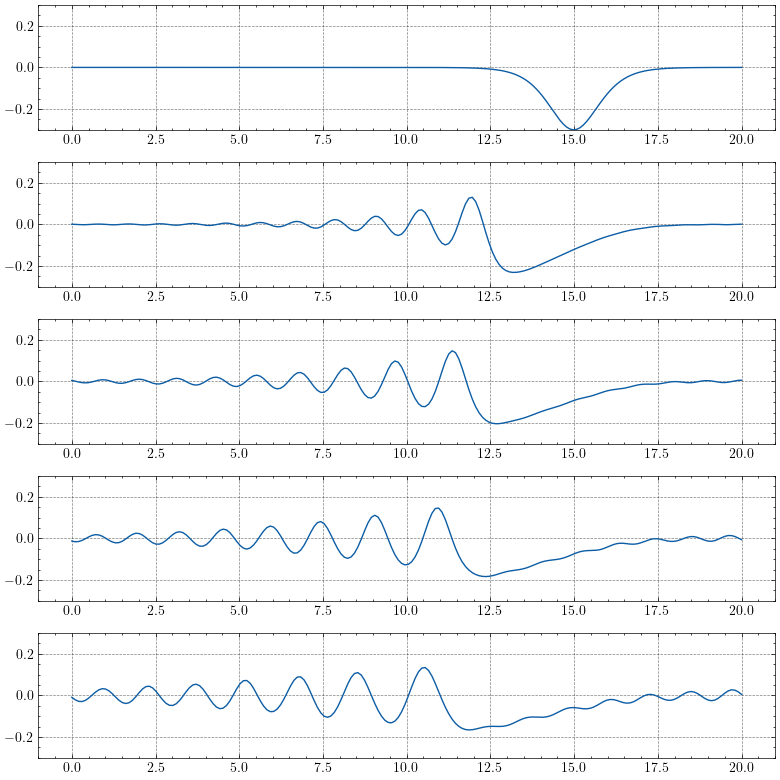

In [202]:
fig, axes = plt.subplots(5, 1, figsize=(8,8))
ymin = -0.3
ymax = 0.3
axes[0].plot(true_coordinates.flatten(),u_strue[1])
axes[0].set_ylim(ymin, ymax)
axes[1].plot(true_coordinates.flatten(),u_strue[int(np.floor(2*number_of_steps/5))])
axes[1].set_ylim(ymin, ymax)
axes[2].plot(true_coordinates.flatten(),u_strue[int(np.floor(3*number_of_steps/5))])
axes[2].set_ylim(ymin, ymax)
axes[3].plot(true_coordinates.flatten(),u_strue[int(np.floor(4*number_of_steps/5))])
axes[3].set_ylim(ymin, ymax)
axes[4].plot(true_coordinates.flatten(),u_strue[int(np.floor(5*number_of_steps/5 - 1))])
axes[4].set_ylim(ymin, ymax)
fig.tight_layout()
plt.show()

In [2]:
import h5py
# f = h5py.File('kdvcubictrue2.h5')
f = h5py.File('data/kdvcubic/kdvcubicnoisy.h5')
fdataset = f['data']

true_alpha = 1.
true_beta = 0.01
sigma_n_true = 0.01

spatial_measurement_coordinates = fdataset['x_grid'][:]
temporal_measurement_coordinates = fdataset['t_grid'][:]
u_observed = fdataset['y'][:]
temporal_measurement_coordinates = temporal_measurement_coordinates[:799]
u_observed = u_observed[:799,:]
temporal_measurement_indices = np.arange(799)

estimate_points = 50
temporal_points = len(temporal_measurement_coordinates)
spatial_points = len(spatial_measurement_coordinates)

number_of_x_axial_cells = 200

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = 0.
x_axis_right_boundary = 20

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
spatial_measurement_indices = np.searchsorted(mesh.p.T.flatten(), spatial_measurement_coordinates)

temp = np.linspace(0, len(u_observed) - 1, estimate_points+1, dtype=int)
estimate_measurement_indices = temporal_measurement_indices[temp[0:-1]]
estimate_measurement_coordinates = temporal_measurement_coordinates[estimate_measurement_indices]

f_true = fdataset['y_true'][:]

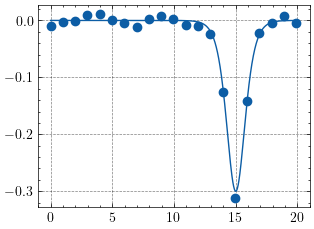

In [6]:
true_space = np.linspace(0, 20, len(f_true[0,:]))
plt.plot(true_space, f_true[0,:])
plt.scatter(spatial_measurement_coordinates, u_observed[0,:])

In [147]:
# Observation Parameters
sigma_n_true = 0.001
spatial_points = 20
temporal_points = 70
estimate_points = 50

# temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
# spatial_measurement_indices = temp[1:-1]
temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+1, dtype=int)
spatial_measurement_indices = temp[0:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]

temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

temp = np.linspace(0, temporal_points - 1, estimate_points+2, dtype=int)
estimate_measurement_indices = temporal_measurement_indices[temp[1:-1]]
estimate_measurement_coordinates = time_range[estimate_measurement_indices]

u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))


(-0.1, 2.5)

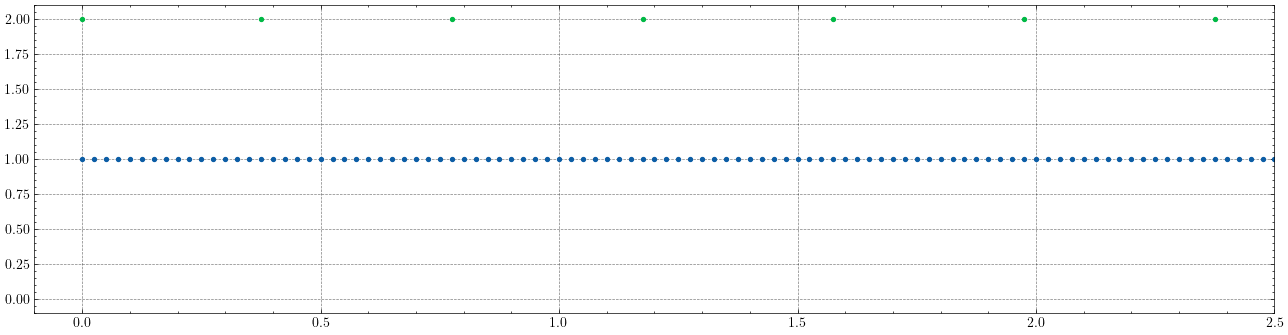

In [7]:
fig, axes = plt.subplots(1,1, figsize=(16,4))
# axes.scatter(time_range, np.zeros(len(time_range)), s=8)
axes.scatter(temporal_measurement_coordinates, np.ones(len(temporal_measurement_coordinates)), s=8)
axes.scatter(estimate_measurement_coordinates, 2*np.ones(len(estimate_measurement_coordinates)), s=8)
axes.set_ylim(-0.1, 2.1)
axes.set_xlim(-0.1, 2.5)

In [8]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 200

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = 0.
x_axis_right_boundary = 20.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.025
t_end = 20 #50.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

mesh = fem.MeshLine(x_s)
v_element = fem.ElementLineP0()
u_element = fem.ElementLineP1()
u_basis = fem.Basis(mesh, u_element)
v_basis = fem.Basis(mesh, v_element)

newton_tol = 0.00001

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*true_coordinates).flatten()
#u_0 = np.exp((-(true_coordinates.flatten())**2)/2)

def sech(x):
    return 1 / np.cosh(x)

u_0 = -0.3*(sech(coordinates.flatten() - 15))**2
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

u_guess = u_0 + np.random.normal(0, 0.0001, len(u_0))
u_guess[0] = u_guess[-1] 
u_guess[-2] = u_guess[1]

v_0 = np.gradient(u_0)
v_s = np.zeros((number_of_steps, n_x))
v_s[0,:] = v_0

v_guess = v_0+ np.random.normal(0, 0.0001, len(v_0))
v_guess[0] = v_guess[-1]
v_guess[-2] = v_guess[1]

w_0 = np.gradient(v_0)
w_s = np.zeros((number_of_steps, n_x))
w_s[0,:] = w_0

w_guess = w_0 + np.random.normal(0, 0.0001, len(w_0))
w_guess[0] = w_guess[-1]
w_guess[-2] = w_guess[1]

# covs = [np.zeros((n_x, n_x))]
covs = np.zeros((number_of_steps, n_x, n_x))
jacobs = np.zeros((number_of_steps, n_x, n_x))

p_sample = 1000

u_parameter_project = np.zeros((p_sample, n_x))
u_parameter_covs = np.zeros((estimate_points, n_x, n_x))

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)
estimate_operator = mark_times(time_range, estimate_measurement_coordinates)

In [9]:
K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta_3 = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)
K_theta_3_np = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

def K_theta_mat(rho, ell):
    K_vec = (rho**2)*at.math.exp(K_theta_3/(2*(ell**2)))
    K_vec = at.reshape(K_vec, (n_x, n_x))
    # return at.nlinalg.kron([[1,0,0],[0,0,0],[0,0,0]], K_vec)
    return K_vec

def K_theta_mat_np(rho, ell):
    K_vec = (rho**2)*np.exp(K_theta_3_np/(2*(ell**2)))
    K_vec = np.reshape(K_vec, (n_x, n_x))
    # return np.kron([[1,0,0],[0,0,0],[0,0,0]], K_vec)
    return K_vec

@fem.BilinearForm
def mass(u,v,w):
    return u*v

mass_mat = mass.assemble(ubasis=u_basis, vbasis=v_basis).toarray()
mass_mat[-1,-1] = mass_mat[-1,0] = mass_mat[0,0]

@fem.BilinearForm
def mixed(u,v,w):
    return grad(u)[0]*v

mixed_mat = mixed.assemble(ubasis=u_basis, vbasis=v_basis).toarray()
mixed_mat[-1,-1] = mixed_mat[0,0]
mixed_mat[-1,0] = mixed_mat[0,1]

ones_mat = np.ones(np.shape(mass_mat))
zeros_mat = np.zeros(np.shape(mass_mat))

ones_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], ones_mat)
ones_12 = np.kron([[0,1,0],[0,0,0],[0,0,0]], ones_mat)
ones_22 = np.kron([[0,0,0],[0,1,0],[0,0,0]], ones_mat)
ones_23 = np.kron([[0,0,0],[0,0,1],[0,0,0]], ones_mat)
ones_31 = np.kron([[0,0,0],[0,0,0],[1,0,0]], ones_mat)
ones_33 = np.kron([[0,0,0],[0,0,0],[0,0,1]], ones_mat)

mass_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], mass_mat)
mass_22 = np.kron([[0,0,0],[0,1,0],[0,0,0]], mass_mat)
mass_33 = np.kron([[0,0,0],[0,0,0],[0,0,1]], mass_mat)

big_mass_mat = mass_11 + 0.5*mass_22 + 0.5*mass_33

mixed_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], mixed_mat)
mixed_12 = np.kron([[0,1,0],[0,0,0],[0,0,0]], mixed_mat)
mixed_23 = np.kron([[0,0,0],[0,0,1],[0,0,0]], mixed_mat)
mixed_31 = np.kron([[0,0,0],[0,0,0],[1,0,0]], mixed_mat)

big_mixed_mat = dt*0.5*mixed_11 + dt*0.5*mixed_12 - 0.5*mixed_23 - 0.5*mixed_31

def fem_lhs(alpha, beta, c, nu, u, v, w, u_prev, v_prev, w_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
    c1 = u - u_prev
    c2 = u + u_prev
    c3 = w + w_prev
    c4 = v + v_prev
    F1 = (mass_mat @ (c1)
          + (dt * nu) * mass_mat @ ((c2) / 2)
          + (dt * alpha) * mixed_mat @ ((c2)**2 / 4) / 2
          + (dt * beta) * mixed_mat @ ((c3) / 2)
          + (dt * c) * mixed_mat @ ((c2) / 2)
          )
    F2 = mass_mat @ ((c3) / 2) - mixed_mat @ ((c4) / 2)
    F3 = mass_mat @ ((c4) / 2) - mixed_mat @ ((c2) / 2)
    return at.concatenate((F1, F2, F3))

def fem_lhs_np(alpha, beta, c, nu, u, v, w, u_prev, v_prev, w_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
    c1 = u - u_prev
    c2 = u + u_prev
    c3 = w + w_prev
    c4 = v + v_prev
    F1 = (mass_mat @ (c1)
          + (dt * nu) * mass_mat @ ((c2) / 2)
          + (dt * alpha) * mixed_mat @ ((c2)**2 / 4) / 2
          + (dt * beta) * mixed_mat @ ((c3) / 2)
          + (dt * c) * mixed_mat @ ((c2) / 2)
          )
    F2 = mass_mat @ ((c3) / 2) - mixed_mat @ ((c4) / 2)
    F3 = mass_mat @ ((c4) / 2) - mixed_mat @ ((c2) / 2)
    return np.concatenate((F1, F2, F3))

def fem_jacobian(alpha, beta, c, nu, u, u_prev, big_mass_mat=big_mass_mat, big_mixed_mat=big_mixed_mat,little_mixed_mat=mixed_mat):
    precompute = at.math.mul(little_mixed_mat, (u+u_prev)/2)
    big_precompute = at.nlinalg.kron([[dt/2,0,0],[0,0,0],[0,0,0]], precompute)
    jacobian1 = at.math.mul(c*ones_11 + beta*ones_12 + ones_23 + ones_31, big_mixed_mat)
    jacobian2 = at.math.mul((1+(dt*nu/2))*ones_11 + ones_22 + ones_33, big_mass_mat)
    jacobian3 = at.math.mul(alpha*ones_11, big_precompute)
    return jacobian1 + jacobian2 + jacobian3

def fem_jacobian_np(alpha, beta, c, nu, u, u_prev, big_mass_mat=big_mass_mat, big_mixed_mat=big_mixed_mat,little_mixed_mat=mixed_mat):
    precompute = np.multiply(little_mixed_mat, (u+u_prev)/2)
    big_precompute = np.kron([[dt/2,0,0],[0,0,0],[0,0,0]], precompute)
    jacobian1 = np.multiply(c*ones_11 + beta*ones_12 + ones_23 + ones_31, big_mixed_mat)
    jacobian2 = np.multiply((1+(dt*nu/2))*ones_11 + ones_22 + ones_33, big_mass_mat)
    jacobian3 = np.multiply(alpha*ones_11, big_precompute)
    return jacobian1 + jacobian2 + jacobian3

def j11(alpha, c, nu, u, u_prev, dt=dt, mass_mat=mass_mat, mixed_mat=mixed_mat):
    return (dt*c/2)*mixed_mat + ((1+dt*nu)/2)*mass_mat + (dt*alpha/2)*np.multiply(mixed_mat, (u + u_prev)/2)

def j12(beta, dt=dt, mixed_mat=mixed_mat):
    return (dt*beta/2)*mixed_mat 

def j22():
    return 0.5*mass_mat

def j23():
    return -0.5*mixed_mat

def j31():
    return -0.5*mixed_mat

def j33():
    return 0.5*mass_mat

J_mat = j22()
nugget = 1e-6*np.eye(n_x)
J_mat_inv = np.linalg.inv(J_mat + nugget)
Kj_mat = j23()
L_mat = j31()
N_mat = j33()

In [16]:
# PRIORS ------------
#alpha
lower = 0.001
upper = 3.
mu = 0.5
sigma = 0.3
alpha_params = [lower, upper, mu, sigma]

# beta
lower = 0.001
upper = 1.
mu = 0.7
sigma = 0.3
beta_params = [lower, upper, mu, sigma]

# c
lower = 0.
upper = 3
mu = 0.
sigma = 0.01
c_params = [lower, upper, mu, sigma]

# nu
lower = 0.
upper = 1.
mu = 0.
sigma = 0.01
nu_params = [lower, upper, mu, sigma]

# rho
lower = 0.001
upper = 1.
mu = 0.1
sigma = 0.1
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.001
upper = 3.
mu = 1.5
sigma = 0.3
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 0.08
mu = 0.05 #0.005
sigma = 0.03
sigma_n_params = [lower, upper, mu, sigma]

# --------------

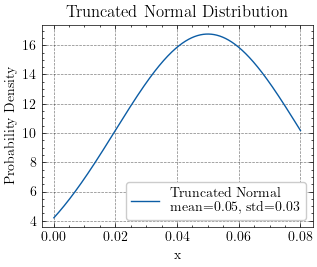

In [17]:
sigma_n_params
test_a, test_b = (sigma_n_params[0] - sigma_n_params[2]) / sigma_n_params[3], (sigma_n_params[1] - sigma_n_params[2]) / sigma_n_params[3]

trunc_dist = truncnorm(test_a, test_b, loc=sigma_n_params[2], scale=sigma_n_params[3])

# Generate x values and corresponding truncated normal y values
x_testing = np.linspace(lower, upper, 1000)
y_testing = trunc_dist.pdf(x_testing)

# Plot the truncated normal distribution
plt.plot(x_testing, y_testing, label=f'Truncated Normal\nmean={sigma_n_params[2]}, std={sigma_n_params[3]}')
plt.title('Truncated Normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
alpha = alpha_params[2]
beta = beta_params[2]
c = c_params[2]
nu = nu_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

traces = [] # box of traces

estimate = True

data_index = 0
estimate_index = 0

for i, t in tqdm(enumerate(time_range[:-1])):
    u_prev, v_prev, w_prev = u_s[i,:], v_s[i,:], w_s[i,:]
    if time_operator[i] == False: # if we do not have data
        for j in range(3):
            f_curr = fem_lhs_np(alpha, beta, c, nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
            j_curr = fem_jacobian_np(alpha, beta, c, nu, u_guess, u_prev)
            j_curr_sparse = scsparse.csr_matrix(j_curr)
            shift = scsparse.linalg.spsolve(j_curr_sparse, -f_curr)
            u_guess += shift[0:n_x]
            w_guess += shift[n_x:2*n_x]
            v_guess += shift[2*n_x:]
        pred_mean = u_guess
        prev_cov = covs[i,:,:]
        jacobian_prev = j11(alpha, c, nu, u_prev, u_s[i-1,:])
        k_mat = K_theta_mat_np(rho, ell)
        Z1_mat = jacobian_prev @ prev_cov @ jacobian_prev.T
        E_mat = j11(alpha, c, nu, pred_mean, u_prev)
        E_mat_inv = np.linalg.inv(E_mat)
        F_mat = j12(beta)
        c1 = E_mat_inv - E_mat_inv @ F_mat @ J_mat_inv @ Kj_mat @ sclinalg.inv(L_mat @ E_mat_inv @ F_mat @ J_mat_inv @ Kj_mat + N_mat) @ L_mat @ E_mat_inv
        c2 = E_mat_inv.T - E_mat_inv.T @ L_mat.T @ sclinalg.inv(Kj_mat.T @ J_mat_inv.T @ F_mat.T @ E_mat_inv.T @ L_mat.T + N_mat.T) @ Kj_mat.T @ J_mat_inv.T @ F_mat.T @ E_mat_inv.T
        cov_1 = c1 @ Z1_mat @ c2
        cov_2 = dt * c1 @ mass_mat @ k_mat @ mass_mat.T @ c2
        pred_cov = cov_1 + cov_2
        u_s[i+1, :] = pred_mean
        v_s[i+1, :] = v_guess
        w_s[i+1, :] = w_guess
        covs[i+1,:,:] = pred_cov
        jacobs[i+1,:,:] = E_mat
    else:
        if estimate == False:
            for j in range(3):
                f_curr = fem_lhs_np(alpha, beta, c, nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
                j_curr = fem_jacobian_np(alpha, beta, c, nu, u_guess, u_prev)
                j_curr_sparse = scsparse.csr_matrix(j_curr)
                shift = scsparse.linalg.spsolve(j_curr_sparse, -f_curr)
                u_guess += shift[0:n_x]
                w_guess += shift[n_x:2*n_x]
                v_guess += shift[2*n_x:]
            pred_mean = u_guess
            prev_cov = covs[i,:,:]
            jacobian_prev = j11(alpha, c, nu, u_prev, u_s[i-1,:])
            k_mat = K_theta_mat_np(rho, ell)
            Z1_mat = jacobian_prev @ prev_cov @ jacobian_prev.T
            E_mat = j11(alpha, c, nu, pred_mean, u_prev)
            E_mat_inv = np.linalg.inv(E_mat)
            F_mat = j12(beta)
            c1 = E_mat_inv - E_mat_inv @ F_mat @ J_mat_inv @ Kj_mat @ sclinalg.inv(L_mat @ E_mat_inv @ F_mat @ J_mat_inv @ Kj_mat + N_mat) @ L_mat @ E_mat_inv
            c2 = E_mat_inv.T - E_mat_inv.T @ L_mat.T @ sclinalg.inv(Kj_mat.T @ J_mat_inv.T @ F_mat.T @ E_mat_inv.T @ L_mat.T + N_mat.T) @ Kj_mat.T @ J_mat_inv.T @ F_mat.T @ E_mat_inv.T
            cov_1 = c1 @ Z1_mat @ c2
            cov_2 = dt * c1 @ mass_mat @ k_mat @ mass_mat.T @ c2
            pred_cov = cov_1 + cov_2
            S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)
            S_n_inverse = np.linalg.inv(S_n)
            updated_mean = pred_mean + pred_cov @ observation_operator.T @ S_n_inverse @ (u_observed[data_index,:] - observation_operator @ pred_mean)
            updated_cov = pred_cov - pred_cov @ observation_operator.T @ S_n_inverse @ observation_operator @ pred_cov
            u_s[i+1, :] = updated_mean
            v_s[i+1, :] = v_guess
            w_s[i+1, :] = w_guess
            covs[i+1,:,:] = updated_cov
            jacobs[i+1,:,:] = E_mat
            data_index += 1
        else:
            if estimate_operator[i] == True:
                # print("We would estimate!")
                with pm.Model() as model:
                    if estimate_index == 0:
                        alpha = pm.TruncatedNormal('alpha', mu=alpha_params[2], sigma=alpha_params[3], lower=alpha_params[0], upper=alpha_params[1])
                        beta = pm.TruncatedNormal('beta', mu=beta_params[2], sigma=beta_params[3], lower=beta_params[0], upper=beta_params[1])
                        # c = pm.TruncatedNormal('c', mu=c_params[2], sigma=c_params[3], lower=c_params[0], upper=c_params[1])
                        # nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
                        rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
                        ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
                        sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])
                    else:
                        alpha = pm.TruncatedNormal('alpha', mu=alpha, sigma=alpha_std, lower=alpha_params[0], upper=alpha_params[1])
                        beta = pm.TruncatedNormal('beta', mu=beta, sigma=beta_std, lower=beta_params[0], upper=beta_params[1])
                        # c = pm.TruncatedNormal('c', mu=c, sigma=c_std, lower=c_params[0], upper=c_params[1])
                        # nu = pm.TruncatedNormal('nu', mu=nu, sigma=nu_std, lower=nu_params[0], upper=nu_params[1])
                        rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_params[0], upper=rho_params[1])
                        ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_params[0], upper=ell_params[1])
                        sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_params[0], upper=sigma_n_params[1])

                    u_prev_var, v_prev_var, w_prev_var = shared(u_prev), shared(v_prev), shared(w_prev)
                    u_prev_prev_var = shared(u_s[i-1,:])
                    state_1 = shared(np.concatenate((u_prev, w_prev, v_prev)))
                    prev_cov_var = shared(covs[i,:,:])
                    dt_var = shared(dt)
                    mass_mat_var = shared(mass_mat)
                    mixed_mat_var = shared(mixed_mat)
                    J_mat_inv_var = shared(J_mat_inv)
                    Kj_mat_var = shared(Kj_mat)
                    L_mat_var = shared(L_mat)
                    N_mat_var = shared(N_mat)
                    H_mat = shared(observation_operator)
                    spatial_points_var = shared(spatial_points)
                    u_observed_var = shared(u_observed[data_index,:])
                    n_x_var = shared(n_x)
                    c_var = shared(c)
                    nu_var = shared(nu)

                    f_curr_1 = fem_lhs(alpha, beta, c_var, nu_var, u_prev_var, v_prev_var, w_prev_var, u_prev_var, v_prev_var, w_prev_var)
                    j_curr_1 = fem_jacobian(alpha, beta, c_var, nu_var, u_prev_var, u_prev_var)

                    state_2 = state_1 + at.slinalg.solve(j_curr_1, -f_curr_1)

                    u_2, w_2, v_2 = at.split(state_2, [n_x_var, n_x_var, n_x_var], n_splits=3)

                    f_curr_2 = fem_lhs(alpha, beta, c_var, nu_var, u_2, v_2, w_2, u_prev_var, v_prev_var, w_prev_var)
                    j_curr_2 = fem_jacobian(alpha, beta, c_var, nu_var, u_2, u_prev_var)

                    state_3 = state_2 + at.slinalg.solve(j_curr_2, -f_curr_2)

                    u_3, w_3, v_3 = at.split(state_3, [n_x_var, n_x_var, n_x_var], n_splits=3)

                    f_curr_3 = fem_lhs(alpha, beta, c_var, nu_var, u_3, v_3, w_3, u_prev_var, v_prev_var, w_prev_var)
                    j_curr_3 = fem_jacobian(alpha, beta, c_var, nu_var, u_3, u_prev_var)

                    state_4 = state_3 + at.slinalg.solve(j_curr_3, -f_curr_3)

                    u_4, w_4, v_4 = at.split(state_4, [n_x_var, n_x_var, n_x_var], n_splits=3)

                    pred_mean = observation_operator @ u_4

                    prev_jacobian = (dt_var*c_var/2)*mixed_mat_var + ((1+dt_var*nu_var)/2)*mass_mat_var + (dt*alpha/2)*mixed_mat_var*((u_prev_var + u_prev_prev_var)/2)
                    k_mat = K_theta_mat(rho, ell)
                    Z1_mat = prev_jacobian @ prev_cov_var @ prev_jacobian.T
                    E_mat = (dt_var*c_var/2)*mixed_mat_var + ((1+dt_var*nu_var)/2)*mass_mat_var + (dt*alpha/2)*mixed_mat_var*((u_4 + u_prev_var)/2)
                    E_mat_inv = at.nlinalg.inv(E_mat)
                    F_mat = (dt_var*beta/2)*mixed_mat_var
                    c1 = E_mat_inv - E_mat_inv @ F_mat @ J_mat_inv_var @ Kj_mat_var @ at.nlinalg.inv(L_mat_var @ E_mat_inv @ F_mat @ J_mat_inv_var @ Kj_mat_var + N_mat_var) @ L_mat_var @ E_mat_inv
                    c2 = E_mat_inv.T - E_mat_inv.T @ L_mat_var.T @ at.nlinalg.inv(Kj_mat_var.T @ J_mat_inv_var.T @ F_mat.T @ E_mat_inv.T @ L_mat_var.T + N_mat_var.T) @ Kj_mat_var.T @ J_mat_inv_var.T @ F_mat.T @ E_mat_inv.T
                    cov_1 = H_mat @ c1 @ Z1_mat @ c2 @ H_mat.T
                    cov_2 = dt_var * H_mat @ c1 @ mass_mat_var @ k_mat @ mass_mat_var.T @ c2 @ H_mat.T
                    pred_cov = cov_1 + cov_2 + (sigma_n**2)*at.eye(spatial_points_var)
                    y_obs = pm.MvNormal('y_obs', mu=pred_mean, cov=pred_cov, observed = u_observed_var)
                    trace = pm.sample(nuts_sampler="numpyro", chains=2, var_names=['alpha', 'beta','rho','ell','sigma_n'])#var_names=['alpha', 'beta', 'c', 'nu','rho','ell','sigma_n'])

                    traces.append(trace)
                
                # update parameters to means of their posteriors
                alpha = np.mean(traces[-1].posterior['alpha'].data.flatten())
                alpha_std = np.std(traces[-1].posterior['alpha'].data.flatten())
                #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
                alpha_updated_params = [alpha_params[0], alpha_params[1], alpha, alpha_std]

                beta = np.mean(traces[-1].posterior['beta'].data.flatten())
                beta_std = np.std(traces[-1].posterior['beta'].data.flatten())
                #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
                beta_updated_params = [beta_params[0], beta_params[1], beta, beta_std]

                # c = np.mean(traces[-1].posterior['c'].data.flatten())
                # c_std = np.std(traces[-1].posterior['c'].data.flatten())
                # #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
                # c_updated_params = [c_params[0], c_params[1], c, c_std]

                # nu = np.mean(traces[-1].posterior['nu'].data.flatten())
                # nu_std = np.std(traces[-1].posterior['nu'].data.flatten())
                # #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
                # nu_updated_params = [nu_params[0], nu_params[1], nu, nu_std]

                rho = np.mean(traces[-1].posterior['rho'].data.flatten())
                rho_std = np.std(traces[-1].posterior['rho'].data.flatten())
                #rho_updated_params = [rho - 3*rho_std, rho + 3*rho_std, rho, rho_std]
                rho_updated_params = [rho_params[0], rho_params[1], rho, rho_std]

                ell = np.mean(traces[-1].posterior['ell'].data.flatten())
                ell_std = np.std(traces[-1].posterior['ell'].data.flatten())
                #ell_updated_params = [ell - 3*ell_std, ell + 3*ell_std, ell, ell_std]
                ell_updated_params = [ell_params[0], ell_params[1], ell, ell_std]

                sigma_n = np.mean(traces[-1].posterior['sigma_n'].data.flatten())
                sigma_n_std = np.std(traces[-1].posterior['sigma_n'].data.flatten())
                #sigma_n_updated_params = [sigma_n- 3*sigma_n_std, sigma_n + 3*sigma_n_std, sigma_n, sigma_n_std]
                sigma_n_updated_params = [sigma_n_params[0], sigma_n_params[1], sigma_n, sigma_n_std]

                full_model_params_vec = np.asarray((traces[-1].posterior['alpha'].data.flatten(), traces[-1].posterior['beta'].data.flatten())).T
                choice_indices = np.random.choice(np.shape(full_model_params_vec)[0], p_sample, replace=False)
                subset_model_params_vec = full_model_params_vec[choice_indices, :]

                counter = 0
                for alpha_s, beta_s in subset_model_params_vec:
                    u_guess_s, v_guess_s, w_guess_s = u_guess, v_guess, w_guess
                    for j in range(3):
                        f_curr_s = fem_lhs_np(alpha_s, beta_s, c, nu, u_guess_s, v_guess_s, w_guess_s, u_prev, v_prev, w_prev)
                        j_curr_s = fem_jacobian_np(alpha_s, beta_s, c, nu, u_guess_s, u_prev)
                        j_curr_sparse_s = scsparse.csr_matrix(j_curr_s)
                        shift_s = scsparse.linalg.spsolve(j_curr_sparse_s, -f_curr_s)
                        u_guess_s += shift_s[0:n_x]
                        w_guess_s += shift_s[n_x:2*n_x]
                        v_guess_s += shift_s[2*n_x:]
                    u_parameter_project[counter, :] = u_guess_s
                    counter += 1

                pred_mean = np.mean(u_parameter_project, axis=0)
                u_parameter_covs[estimate_index, :, :] = np.cov(u_parameter_project, rowvar=False)
                
                prev_cov = covs[i,:,:]
                jacobian_prev = j11(alpha, c, nu, u_prev, u_s[i-1,:])
                k_mat = K_theta_mat_np(rho, ell)
                Z1_mat = jacobian_prev @ prev_cov @ jacobian_prev.T
                E_mat = j11(alpha, c, nu, pred_mean, u_prev)
                E_mat_inv = np.linalg.inv(E_mat)
                F_mat = j12(beta)
                c1 = E_mat_inv - E_mat_inv @ F_mat @ J_mat_inv @ Kj_mat @ sclinalg.inv(L_mat @ E_mat_inv @ F_mat @ J_mat_inv @ Kj_mat + N_mat) @ L_mat @ E_mat_inv
                c2 = E_mat_inv.T - E_mat_inv.T @ L_mat.T @ sclinalg.inv(Kj_mat.T @ J_mat_inv.T @ F_mat.T @ E_mat_inv.T @ L_mat.T + N_mat.T) @ Kj_mat.T @ J_mat_inv.T @ F_mat.T @ E_mat_inv.T
                cov_1 = c1 @ Z1_mat @ c2
                cov_2 = dt * c1 @ mass_mat @ k_mat @ mass_mat.T @ c2
                pred_cov = cov_1 + cov_2
                S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)
                S_n_inverse = np.linalg.inv(S_n)
                updated_mean = pred_mean + pred_cov @ observation_operator.T @ S_n_inverse @ (u_observed[data_index,:] - observation_operator @ pred_mean)
                updated_cov = pred_cov - pred_cov @ observation_operator.T @ S_n_inverse @ observation_operator @ pred_cov
                u_s[i+1, :] = updated_mean
                v_s[i+1, :] = v_guess
                w_s[i+1, :] = w_guess
                covs[i+1,:,:] = updated_cov
                jacobs[i+1,:,:] = E_mat
                data_index += 1
                estimate_index += 1
            else:
                for j in range(3):
                    f_curr = fem_lhs_np(alpha, beta, c, nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
                    j_curr = fem_jacobian_np(alpha, beta, c, nu, u_guess, u_prev)
                    j_curr_sparse = scsparse.csr_matrix(j_curr)
                    shift = scsparse.linalg.spsolve(j_curr_sparse, -f_curr)
                    u_guess += shift[0:n_x]
                    w_guess += shift[n_x:2*n_x]
                    v_guess += shift[2*n_x:]
                pred_mean = u_guess
                prev_cov = covs[i,:,:]
                jacobian_prev = j11(alpha, c, nu, u_prev, u_s[i-1,:])
                k_mat = K_theta_mat_np(rho, ell)
                Z1_mat = jacobian_prev @ prev_cov @ jacobian_prev.T
                E_mat = j11(alpha, c, nu, pred_mean, u_prev)
                E_mat_inv = np.linalg.inv(E_mat)
                F_mat = j12(beta)
                c1 = E_mat_inv - E_mat_inv @ F_mat @ J_mat_inv @ Kj_mat @ sclinalg.inv(L_mat @ E_mat_inv @ F_mat @ J_mat_inv @ Kj_mat + N_mat) @ L_mat @ E_mat_inv
                c2 = E_mat_inv.T - E_mat_inv.T @ L_mat.T @ sclinalg.inv(Kj_mat.T @ J_mat_inv.T @ F_mat.T @ E_mat_inv.T @ L_mat.T + N_mat.T) @ Kj_mat.T @ J_mat_inv.T @ F_mat.T @ E_mat_inv.T
                cov_1 = c1 @ Z1_mat @ c2
                cov_2 = dt * c1 @ mass_mat @ k_mat @ mass_mat.T @ c2
                pred_cov = cov_1 + cov_2
                S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)
                S_n_inverse = np.linalg.inv(S_n)
                updated_mean = pred_mean + pred_cov @ observation_operator.T @ S_n_inverse @ (u_observed[data_index,:] - observation_operator @ pred_mean)
                updated_cov = pred_cov - pred_cov @ observation_operator.T @ S_n_inverse @ observation_operator @ pred_cov
                u_s[i+1, :] = updated_mean
                v_s[i+1, :] = v_guess
                w_s[i+1, :] = w_guess
                covs[i+1,:,:] = updated_cov
                jacobs[i+1,:,:] = E_mat
                data_index += 1

0it [00:00, ?it/s]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
15it [16:20, 12.89s/it]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least 4 chains for robust computation of convergence diagnostics
30it [26:50,  8.67s/it] /home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms

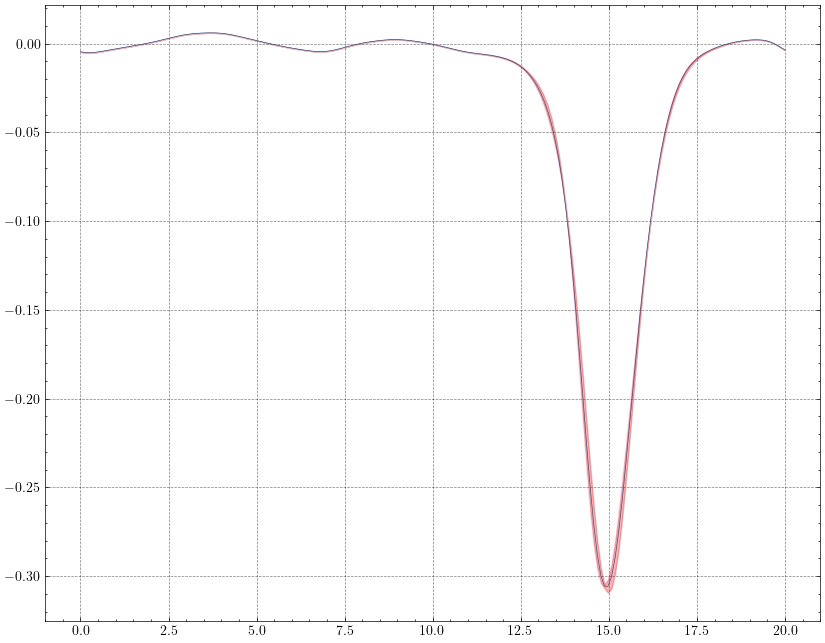

In [19]:
fig, axes = plt.subplots(figsize=(10,8))

tinde = 1

axes.plot(coordinates.flatten(), u_s[tinde,:], linewidth=0.5)
# plt.plot(coordinates.flatten(), u_s[1,:])
axes.fill_between(coordinates.flatten(), u_s[tinde,:] + 2*np.sqrt(np.diag(u_parameter_covs[tinde-1,:,:])), u_s[tinde,:] - 2*np.sqrt(np.diag(u_parameter_covs[tinde-1,:,:])), color='red', alpha=0.3)
# axes.set_xlim(12.5, 17.5)

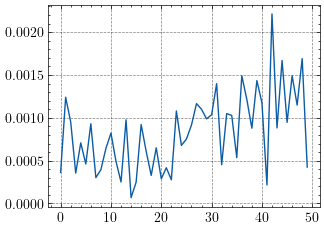

In [20]:
plt.plot(2*np.sqrt(np.max((np.diagonal(u_parameter_covs)), axis=0)))

In [21]:
import pickle
try:
    # Assuming the variables are already defined, we'll create the dictionary
    true_model_dict = {
        "true_alpha": true_alpha,
        "true_beta": true_beta,
        "true_c": true_c,
        "true_nu": true_nu,
        "true_coordinates": true_coordinates,
        "u_strue": u_strue,
        "u_observed": u_observed,
        "sigma_n_true": sigma_n_true,
        "spatial_points": spatial_points,
        "temporal_points": temporal_points,
        "spatial_measurement_indices": spatial_measurement_indices,
        "spatial_measurement_coordinates": spatial_measurement_coordinates,
        "temporal_measurement_indices": temporal_measurement_indices,
        "temporal_measurement_coordinates": temporal_measurement_coordinates
    }

    # Pickling the dictionary
    with open('noisy_true_model_dict.pkl', 'wb') as f:
        pickle.dump(true_model_dict, f)
except:
    print('Failed')

try:
    predict_model_dict = {
        "t_start": t_start,
        "dt": dt,
        "t_end": t_end,
        "time_range": time_range,
        "number_of_steps": number_of_steps,
        "coordinates": coordinates,
        "u_0": u_0,
        "u_s": u_s,
        "v_0": v_0,
        "v_s": v_s,
        "w_0": w_0,
        "w_s": w_s,
        "covs": covs,
        "jacobs": jacobs,
        "param_covs": u_parameter_covs,
        "observation_operator": observation_operator,
        "time_operator": time_operator,
        "alpha_params": alpha_params,
        "beta_params": beta_params,
        "c_params": c_params,
        "nu_params": nu_params,
        "rho_params": rho_params,
        "ell_params": ell_params,
        "sigma_n_params": sigma_n_params
    }

    # Pickling the dictionary
    with open('noisy_kdv_predict_model_dict.pkl', 'wb') as f:
        pickle.dump(predict_model_dict, f)
except:
    print('Failed')

try:
    for i, trace in enumerate(traces):
        trace.to_netcdf(f'kdv_traces/noisy_kdv_trace_{i}.nc')
except:
    print('Failed')

Failed


In [ ]:
# LOADING

# Initialize an empty list to store the loaded traces
# traces = []

# Loop through the saved NetCDF files and load each trace
# for i in range(200):
#     trace = az.from_netcdf(f'pymc_trace_{i}.nc')
#     traces.append(trace)

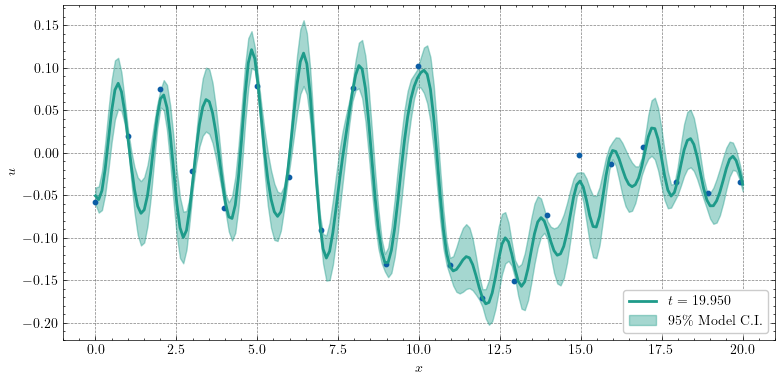

In [25]:
# sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]

time_index = 798
time_labels = [r"$t=$ "+ f"{time_range[i]:.3f}" for i in range(len(time_range))]

fig, axes = plt.subplots(figsize=(8,4))

axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[5], linewidth=2.)
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[5], label=r'$95\%$ Model C.I.')
#axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(cov_diags[time_index]) - 2*np.mean(sigma_n_estimates[-1]), u_s[time_index,:] - 2*np.sqrt(cov_diags[time_index]), alpha=0.3, color=color_list[5], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
#axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(cov_diags[time_index]), u_s[time_index,:] + 2*np.sqrt(cov_diags[time_index]) + 2*np.mean(sigma_n_estimates[-1]), alpha=0.3, color=color_list[5], hatch=r"\ ")

# axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted', linewidth=2.)
# axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')
axes.scatter(spatial_measurement_coordinates, u_observed[time_index,:], s=10)

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower right')
fig.tight_layout()
plt.show()
plt.close()

In [182]:
temporal_measurement_indices

array([ 15,  31,  47,  62,  78,  94, 109, 125, 141, 156, 172, 188, 203,
       219, 235, 250, 266, 282, 297, 313, 329, 344, 360, 376, 391, 407,
       423, 438, 454, 470, 485, 501, 517, 532, 548, 564, 579, 595, 611,
       626, 642, 658, 673, 689, 705, 720, 736, 752, 767, 783])

/tmp/ipykernel_298135/3545335599.py:11: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*over_time_sigma_est[time_index], u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[7], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
/tmp/ipykernel_298135/3545335599.py:12: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*over_time_sigma_est[time_index], alpha=0.3, c

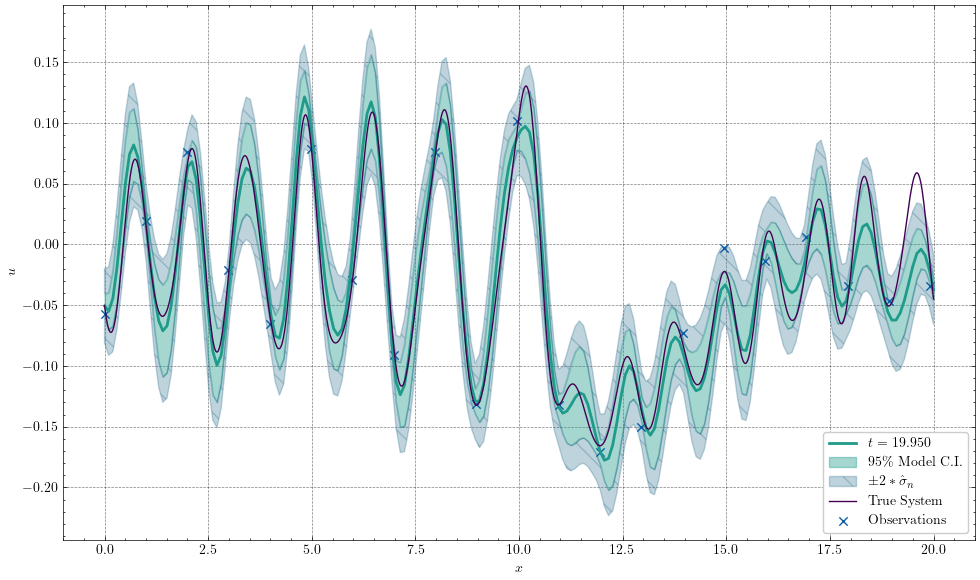

In [27]:
sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]
over_time_sigma_est = np.repeat(np.median(sigma_n_estimates, axis=1), 16)

time_index = 798
time_labels = [r"$t=$ "+ f"{time_range[i]:.03f}" for i in range(len(time_range))]

fig, axes = plt.subplots(figsize=(10,6))

axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[5], linewidth=2.)
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[5], label=r'$95\%$ Model C.I.')
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*over_time_sigma_est[time_index], u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[7], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*over_time_sigma_est[time_index], alpha=0.3, color=color_list[7], hatch=r"\ ")

axes.plot(true_space, f_true[time_index,:], label='True System', color=color_list[11], linewidth=1.)
# axes.fill_between(true_space, u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')

axes.scatter(spatial_measurement_coordinates, u_observed[time_index,:], marker='x', label='Observations')

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower right')
fig.tight_layout()

In [28]:
for time_index in tqdm(range(len(time_range)-1)):
    filename = r"kdv_pics/image" + str(time_index) + ".png"

    fig, axes = plt.subplots(figsize=(8,4))

    axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[5], linewidth=2.)
    axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[5], label=r'$95\%$ Model C.I.')
    axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*over_time_sigma_est[time_index], u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[7], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
    axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*over_time_sigma_est[time_index], alpha=0.3, color=color_list[7], hatch=r"\ ")

    axes.plot(true_space, f_true[time_index,:], label='True System', color=color_list[11], linewidth=1.)
    # axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')
    axes.scatter(spatial_measurement_coordinates, u_observed[time_index,:], marker='x', label='Observations')

    axes.set_xlabel(r'$x$')
    axes.set_ylabel(r'$u$')
    axes.set_ylim(-0.4, 0.4)

    axes.legend(loc='lower right')
    fig.tight_layout()

    plt.savefig(filename)
    plt.close()

#ffmpeg -framerate 48 -i 'image%d.png' -c:v libx264 -pix_fmt yuv420p ../kdvvid.mp4



  0%|          | 0/799 [00:00<?, ?it/s]/tmp/ipykernel_298135/3850770332.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*over_time_sigma_est[time_index], u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[7], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
/tmp/ipykernel_298135/3850770332.py:9: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*over_tim

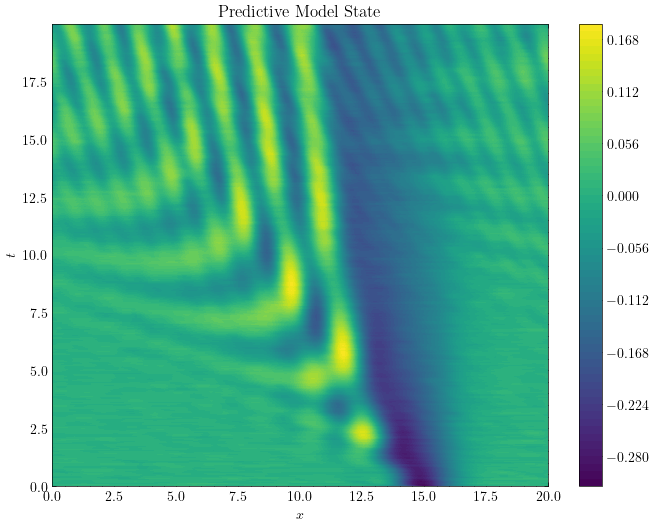

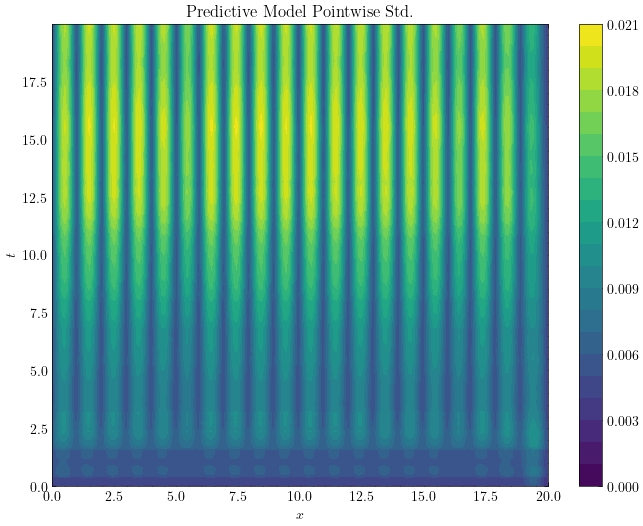

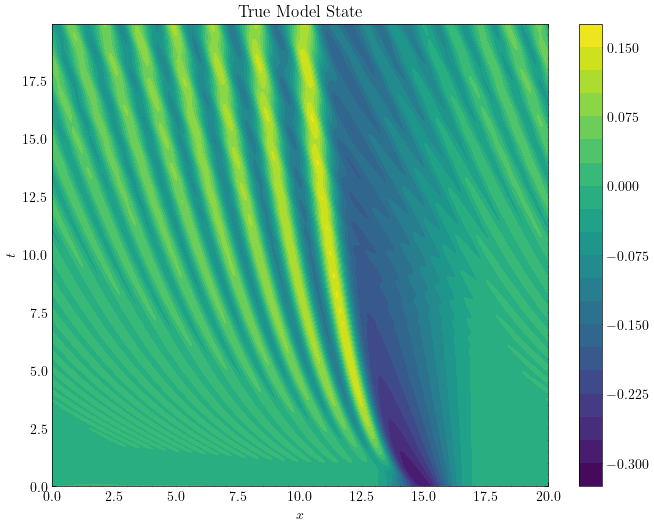

In [29]:
fig, axes = plt.subplots(figsize=(8,6))
plot = axes.contourf(coordinates.flatten(), time_range, u_s, levels=contour_levels+50)
# num = 0
# for coord in spatial_measurement_coordinates.flatten():
#     if num == 0:
#         axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
#     else:
#         axes.axvline(coord, linestyle='--', color='black')
#     num += 1
# num = 0
# for coord in temporal_measurement_coordinates.flatten():
#     if num == 0:
#         axes.axhline(coord, linestyle='--', color='black')
#     else:
#         axes.axhline(coord, linestyle='--', color='black')
#     num += 1

# x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
# x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('Predictive Model State')
fig.colorbar(plot)
# plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(8,6))
plot = axes.contourf(coordinates.flatten(), time_range, np.sqrt(np.diagonal(covs, axis1=1, axis2=2)), levels=contour_levels)
# num = 0
# for coord in spatial_measurement_coordinates.flatten():
#     if num == 0:
#         axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
#     else:
#         axes.axvline(coord, linestyle='--', color='black')
#     num += 1
# num = 0
# for coord in temporal_measurement_coordinates.flatten():
#     if num == 0:
#         axes.axhline(coord, linestyle='--', color='black')
#     else:
#         axes.axhline(coord, linestyle='--', color='black')
#     num += 1

# x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
# x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('Predictive Model Pointwise Std.')
fig.colorbar(plot)
# plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(8,6))
# plot = axes.contourf(spatial_measurement_coordinates.flatten(), temporal_measurement_coordinates, u_observed, levels=contour_levels+50)
plot = axes.contourf(true_space, temporal_measurement_coordinates, f_true[:len(temporal_measurement_coordinates),:], levels=contour_levels)
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
# axes.set_title('Observed Model State')
axes.set_title('True Model State')
fig.colorbar(plot)
# plt.legend()
plt.show()

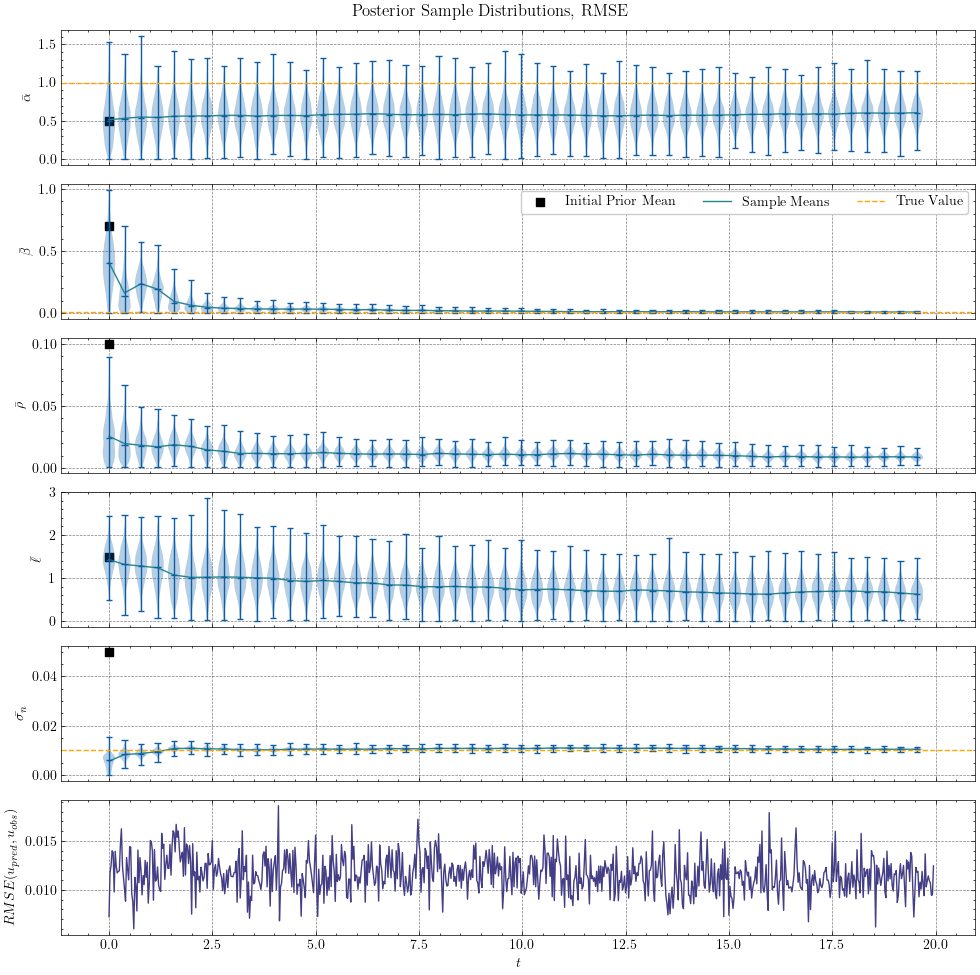

In [30]:
alpha_estimates = [traces[i].posterior['alpha'].data.flatten() for i in range(len(traces))]
beta_estimates = [traces[i].posterior['beta'].data.flatten() for i in range(len(traces))]
rho_estimates = [traces[i].posterior['rho'].data.flatten() for i in range(len(traces))]
ell_estimates = [traces[i].posterior['ell'].data.flatten() for i in range(len(traces))]
sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]

rms_obs = np.sqrt(np.mean((np.asarray([observation_operator @ u_s[i,:] for i in temporal_measurement_indices]) - np.asarray([u_observed[i,:] for i in range(temporal_points)]))**2, axis=1))
# rms_true = np.sqrt(np.mean((u_s - u_strue)**2, axis=1))
plot_time_coords = estimate_measurement_coordinates

fig, axs = plt.subplots(6, 1, figsize=(10, 10), sharex=True)

axs[0].scatter(0, (alpha_params[2]), marker='s', color='black', label='Initial Prior Mean')
axs[0].plot(plot_time_coords, [(np.mean(trace_set)) for trace_set in alpha_estimates], label='Sample Means', color=color_list[6])#, linestyle='dashed')
# axs[0].fill_between(plot_time_coords, [(np.mean(trace_set) - 2*np.std(trace_set)) for trace_set in alpha_estimates], [(np.mean(trace_set) + 2*np.std(trace_set)) for trace_set in alpha_estimates], color=color_list[6], alpha=0.1, label=r'$\pm 2\hat{\sigma}$')
axs[0].violinplot(dataset=alpha_estimates, positions=plot_time_coords, showmedians=True, widths=0.3)
#axs[0].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in nu_estimates], marker='x', color='black', label='Sample Means')
#axs[0].set_ylim((10**nu_params[0],10**nu_params[1]))
axs[0].axhline(true_alpha, color='orange', linestyle='dashed', label='True Value')
# axs[0].legend(loc='upper right', ncols=3)
axs[0].set_ylabel(r'$\bar{\alpha}$')

axs[1].scatter(0, (beta_params[2]), marker='s', color='black', label='Initial Prior Mean')
axs[1].plot(plot_time_coords, [(np.mean(trace_set)) for trace_set in beta_estimates], label='Sample Means', color=color_list[6])#, linestyle='dashed')
# axs[1].fill_between(plot_time_coords, [(np.mean(trace_set) - 2*np.std(trace_set)) for trace_set in beta_estimates], [(np.mean(trace_set) + 2*np.std(trace_set)) for trace_set in beta_estimates], color=color_list[6], alpha=0.1, label=r'$\pm 2\hat{\sigma}$')
axs[1].violinplot(dataset=beta_estimates, positions=plot_time_coords, showmedians=True, widths=0.3)
#axs[0].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in nu_estimates], marker='x', color='black', label='Sample Means')
#axs[0].set_ylim((10**nu_params[0],10**nu_params[1]))
axs[1].axhline(true_beta, color='orange', linestyle='dashed', label='True Value')
axs[1].legend(loc='upper right', ncols=3)
axs[1].set_ylabel(r'$\bar{\beta}$')

axs[2].scatter(0, rho_params[2], marker='s', color='black', label='Initial Prior Mean')
axs[2].plot(plot_time_coords, [np.mean(trace_set) for trace_set in rho_estimates], label='Rho Estimates', color=color_list[6])#, linestyle='dashed')
# axs[2].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in rho_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in rho_estimates], color=color_list[6], alpha=0.1)
#axs[1].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in rho_estimates], marker='x', color='black')
axs[2].violinplot(dataset=rho_estimates, positions=plot_time_coords, showmedians=True, widths=0.3)
axs[2].set_ylabel(r'$\bar{\rho}$')

axs[3].scatter(0, ell_params[2], marker='s', color='black', label='Initial Prior Mean')
axs[3].plot(plot_time_coords,[np.mean(trace_set) for trace_set in ell_estimates], label='Ell Estimates', color=color_list[6])#, linestyle='dashed')
# axs[3].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in ell_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in ell_estimates], color=color_list[6], alpha=0.1)
#axs[2].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in ell_estimates], marker='x', color='black')
axs[3].violinplot(dataset=ell_estimates, positions=plot_time_coords, showmedians=True, widths=0.3)
axs[3].set_ylabel(r'$\bar{\ell}$')

axs[4].scatter(0, sigma_n_params[2], marker='s', color='black', label='Initial Prior Mean')
axs[4].plot(plot_time_coords, [np.mean(trace_set) for trace_set in sigma_n_estimates], label='Sigma_n Estimates', color=color_list[6])#, linestyle='dashed')
# axs[4].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in sigma_n_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in sigma_n_estimates], color=color_list[6], alpha=0.1)
#axs[3].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in sigma_n_estimates], marker='x', color='black')
axs[4].violinplot(dataset=sigma_n_estimates, positions=plot_time_coords, showmedians=True, widths=0.3)
axs[4].axhline(sigma_n_true, color='orange', linestyle='dashed')
axs[4].set_ylabel(r'$\bar{\sigma_n}$')

# axs[5].plot(time_range, rms_true, label='True RMS Error', color=color_list[6])
axs[5].plot(temporal_measurement_coordinates, rms_obs, label='Obs. RMS Error', color=color_list[9])
axs[5].set_ylabel(r'$RMSE(u_{pred}, u_{obs})$')
axs[5].set_xlabel(r'$t$')

fig.suptitle('Posterior Sample Distributions, RMSE')
fig.tight_layout()
# Adjust layout
#plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()
plt.close()

In [14]:
u_prev_test, v_prev_test, w_prev_test = u_prev, v_prev, w_prev
u_prev_prev_test = u_s[-2,:]
state_test = np.concatenate((u_prev_test, v_prev_test, w_prev_test))
prev_cov_test = covs[-1,:,:]
u_observed_test = u_observed[-1,:]

with pm.Model() as model:
    alpha = pm.TruncatedNormal('alpha', mu=alpha_params[2], sigma=alpha_params[3], lower=alpha_params[0], upper=alpha_params[1])
    beta = pm.TruncatedNormal('beta', mu=beta_params[2], sigma=beta_params[3], lower=beta_params[0], upper=beta_params[1])
    c = pm.TruncatedNormal('c', mu=c_params[2], sigma=c_params[3], lower=c_params[0], upper=c_params[1])
    nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
    #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
    rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
    ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])

    u_prev_var, v_prev_var, w_prev_var = shared(u_prev_test), shared(v_prev_test), shared(w_prev_test)
    u_prev_prev_var = shared(u_prev_prev_test)
    state_1 = shared(state_test)
    prev_cov_var = shared(prev_cov_test)
    dt_var = shared(dt)
    mass_mat_var = shared(mass_mat)
    mixed_mat_var = shared(mixed_mat)
    J_mat_inv_var = shared(J_mat_inv)
    Kj_mat_var = shared(Kj_mat)
    L_mat_var = shared(L_mat)
    N_mat_var = shared(N_mat)
    H_mat = shared(observation_operator)
    spatial_points_var = shared(spatial_points)
    u_observed_var = shared(u_observed_test)
    n_x_var = shared(n_x)

    f_curr_1 = fem_lhs(alpha, beta, c, nu, u_prev_var, v_prev_var, w_prev_var, u_prev_var, v_prev_var, w_prev_var)
    j_curr_1 = fem_jacobian(alpha, beta, c, nu, u_prev_var, u_prev_var)

    state_2 = state_test + at.slinalg.solve(j_curr_1, -f_curr_1)

    u_2, v_2, w_2 = at.split(state_2, [n_x_var, n_x_var, n_x_var], n_splits=3)

    f_curr_2 = fem_lhs(alpha, beta, c, nu, u_2, v_2, w_2, u_prev_var, v_prev_var, w_prev_var)
    j_curr_2 = fem_jacobian(alpha, beta, c, nu, u_2, u_prev_var)

    state_3 = state_2 + at.slinalg.solve(j_curr_2, -f_curr_2)

    u_3, v_3, w_3 = at.split(state_3, [n_x_var, n_x_var, n_x_var], n_splits=3)

    f_curr_3 = fem_lhs(alpha, beta, c, nu, u_3, v_3, w_3, u_prev_var, v_prev_var, w_prev_var)
    j_curr_3 = fem_jacobian(alpha, beta, c, nu, u_3, u_prev_var)

    state_4 = state_test + at.slinalg.solve(j_curr_3, -f_curr_3)

    u_4, v_4, w_4 = at.split(state_4, [n_x_var, n_x_var, n_x_var], n_splits=3)

    pred_mean = observation_operator @ u_4

    prev_jacobian = (dt_var*c/2)*mixed_mat_var + ((1+dt_var*nu)/2)*mass_mat_var + (dt*alpha/2)*mixed_mat_var*((u_prev_var + u_prev_prev_var)/2)
    k_mat = K_theta_mat(rho, ell)
    Z1_mat = prev_jacobian @ prev_cov_var @ prev_jacobian.T
    E_mat = (dt_var*c/2)*mixed_mat_var + ((1+dt_var*nu)/2)*mass_mat_var + (dt*alpha/2)*mixed_mat_var*((u_4 + u_prev_var)/2)
    E_mat_inv = at.nlinalg.inv(E_mat)
    F_mat = (dt_var*beta/2)*mixed_mat_var
    c1 = E_mat_inv - E_mat_inv @ F_mat @ J_mat_inv_var @ Kj_mat_var @ at.nlinalg.pinv(L_mat_var @ E_mat_inv @ F_mat @ J_mat_inv_var @ Kj_mat_var + N_mat_var) @ L_mat_var @ E_mat_inv
    c2 = E_mat_inv.T - E_mat_inv.T @ L_mat_var.T @ at.nlinalg.pinv(Kj_mat_var.T @ J_mat_inv_var.T @ F_mat.T @ E_mat_inv.T @ L_mat_var.T + N_mat_var.T) @ Kj_mat_var.T @ J_mat_inv_var.T @ F_mat.T @ E_mat_inv.T
    cov_1 = H_mat @ c1 @ Z1_mat @ c2 @ H_mat.T
    cov_2 = dt_var * H_mat @ c1 @ mass_mat_var @ k_mat @ mass_mat_var.T @ c2 @ H_mat.T
    pred_cov = cov_1 + cov_2 + (sigma_n**2)*at.eye(spatial_points_var)
    cov_chol = at.linalg.cholesky(pred_cov)
    y_obs = pm.MvNormal('y_obs', mu=pred_mean, chol=cov_chol, observed = u_observed_var)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'ell'}>, <Axes: title={'center': 'ell'}>],
       [<Axes: title={'center': 'rho'}>, <Axes: title={'center': 'rho'}>],
       [<Axes: title={'center': 'sigma_n'}>,
        <Axes: title={'center': 'sigma_n'}>]], dtype=object)

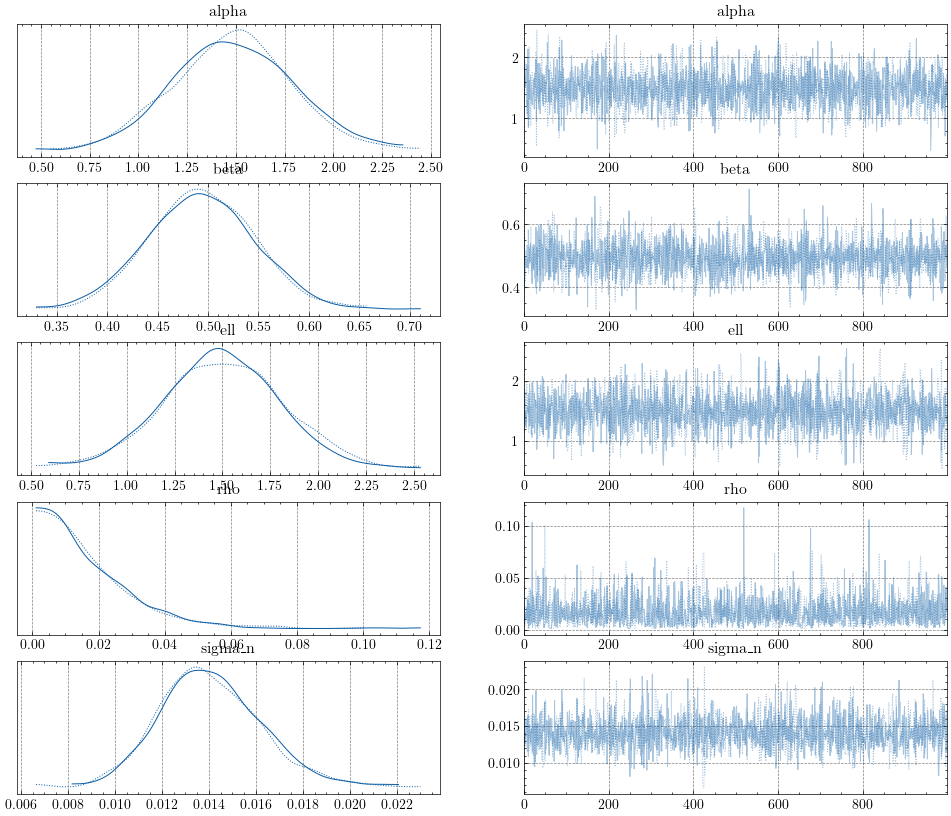

In [84]:
az.plot_trace(traces[2])

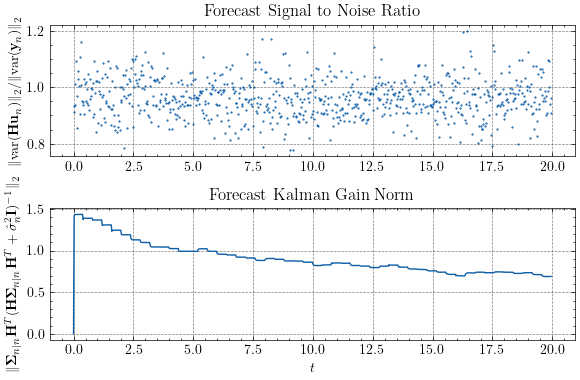

In [31]:
fig, axes = plt.subplots(nrows=2, figsize=(6,4))

statistic_1 = [np.abs(np.var(observation_operator @ u_s[temporal_measurement_indices[i],:])) / np.abs(np.var(u_observed[i,:])) for i in range(temporal_points)]
statistic_2 = [np.linalg.svd(covs[temporal_measurement_indices[i],:,:] @ observation_operator.T @ np.linalg.inv(observation_operator @ covs[temporal_measurement_indices[i],:,:] @ observation_operator.T + (over_time_sigma_est[i]**2)*np.eye(spatial_points))).S[0] for i in range(temporal_points)]

sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]

axes[0].scatter(temporal_measurement_coordinates, statistic_1, s=0.3)
axes[0].set_title('Forecast Signal to Noise Ratio')
axes[0].set_ylabel(r'$\Vert \text{var} (\mathbf{Hu}_n) \Vert_2 / \Vert \text{var}(\mathbf{y}_n)\Vert_2$')

axes[1].plot(temporal_measurement_coordinates,statistic_2)
axes[1].set_title('Forecast Kalman Gain Norm')
axes[1].set_ylabel(r'$\Vert \mathbf{\Sigma}_{n|n} \mathbf{H}^T(\mathbf{H}\mathbf{\Sigma}_{n|n}\mathbf{H}^T + \hat{\sigma}^2_n\mathbf{I})^{-1}\Vert_2$')
axes[1].set_xlabel(r'$t$')

fig.tight_layout()

In [46]:
temporal_measurement_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
estimate_measurement_coordinates